In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import glob
import pandas as pd
import mplniw.utils as ut
from datetime import timedelta, datetime


In [2]:
root_dir = '/Users/zcasparcohen/Documents/NISKINE/data/'
os.listdir(root_dir)

['v1',
 '.DS_Store',
 'FQ_InterpolatedFinal.mat',
 'niskine_mooring_locations.nc',
 't_10m_2min.nc',
 'gridded']

In [109]:
def interpolation(arraylist, z_new, t_new, fill_gaps=True, **kwargs):
    # Sorting down and up adcps:
    down = [v for v in arraylist if v.orientation=='down']
    up = [v for v in arraylist if v.orientation=='up']
    #Subsampling
    down_sub = [v.sel(time=slice(t_new[0],t_new[-1])) for v in down]
    up_sub = [v.sel(time=slice(t_new[0],t_new[-1])) for v in up]
    # Interpolation on a regular temporal grid
    down_interp = [v.interp(time=t_new) for v in down_sub if v.time.size>=10000]
    up_interp = [v.interp(time=t_new) for v in up_sub if v.time.size>=10000]
    down_interpz = [v.interp(z=z_new) for v in down_interp]
    up_interpz = [v.interp(z=z_new) for v in up_interp]
    if len(down_interpz)==2:
        _=down_interpz[1].combine_first(down_interpz[0])
    elif len(down_interpz)==1:
        _=down_interpz[0]
    else:
        _=down_interpz[1].combine_first(down_interpz[0]).combine_first(down_interpz[2])
    if len(up_interpz)==1:
        ds = up_interpz[0].combine_first(_)
    elif len(up_interpz)==2:
        ds = up_interpz[0].combine_first(up_interpz[1]).combine_first(_)
    else:
        ds = _
        
    if fill_gaps:
        return ds,ds.interpolate_na(dim='z',**kwargs)
    else:
        return ds
   # return down_interpz,up_interpz

def plot_uv(_ds,V,fig,ax,cmap = 'coolwarm', vmax=0.4,**kwargs):
    _ds[V].plot(ax=ax, yincrease=False,vmax=vmax,cmap=cmap, **kwargs)
    return fig,ax

In [129]:
mooring = 'M2'
listfile = sorted(filter(os.path.isfile,glob.glob(root_dir+'v1/'+mooring+'*')))
arraylist = [xr.open_dataset(file) for file in listfile]

t_new = pd.date_range(start='2019-05-17T16', end='2020-10-06T00', freq=timedelta(minutes=10))
z_new = np.arange(0,2000,16)

In [131]:
ds,ds_fill = interpolation(arraylist,z_new,t_new,**{'method':'linear'})
#ds_cubic,ds_fill_cubic = interpolation(arraylist,z_new,t_new,**{'method':'cubic'})

In [132]:
ds_gridded = xr.open_dataset(root_dir+'gridded/'+mooring+'_gridded_simple_merge_gaps_filled.nc')
ds_gaps = xr.open_dataset(root_dir+'gridded/'+mooring+'_gridded_simple_merge.nc')

(<Figure size 1200x500 with 4 Axes>, <Axes: xlabel='time', ylabel='depth [m]'>)

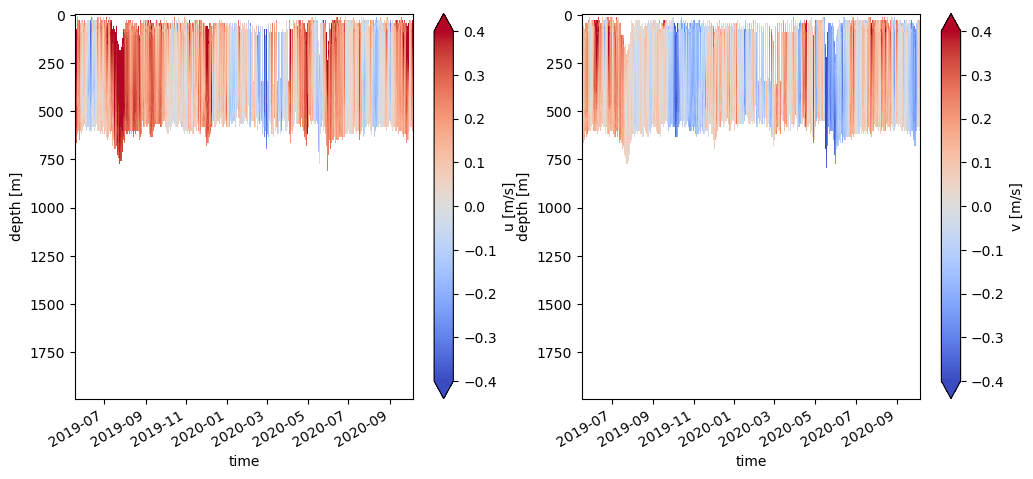

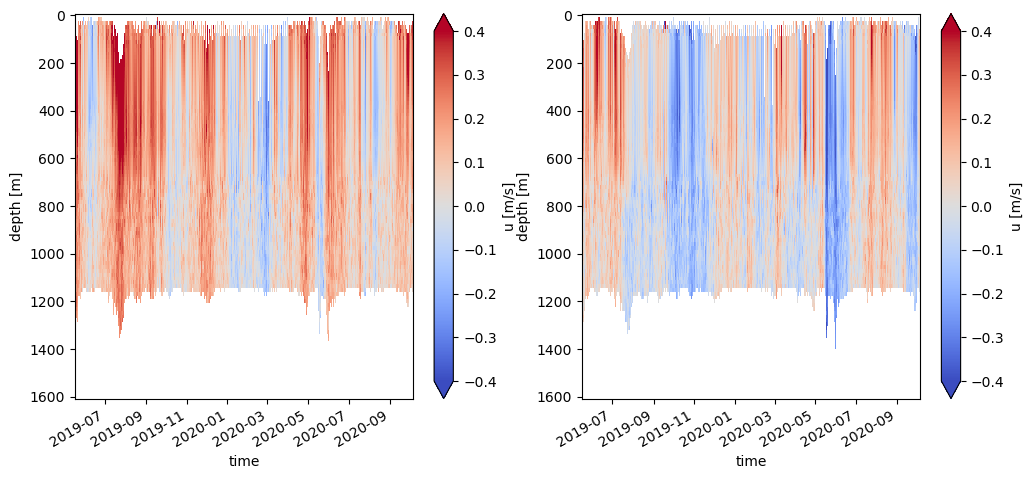

In [133]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plot_uv(ds_fill,'u',fig,ax)
ax = fig.add_subplot(122)
plot_uv(ds_fill,'v',fig,ax)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plot_uv(ds_gridded,'u',fig,ax)
ax = fig.add_subplot(122)
plot_uv(ds_gridded,'v',fig,ax)

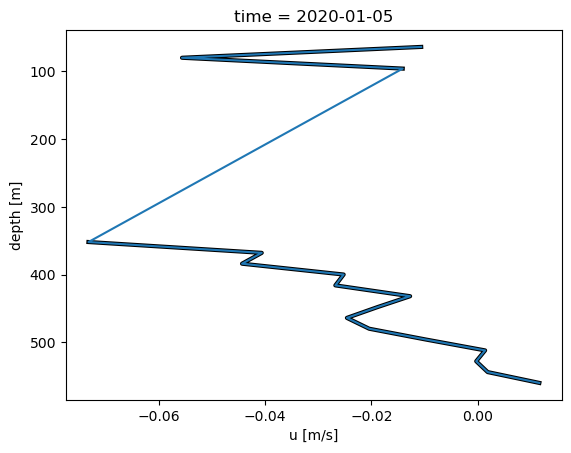

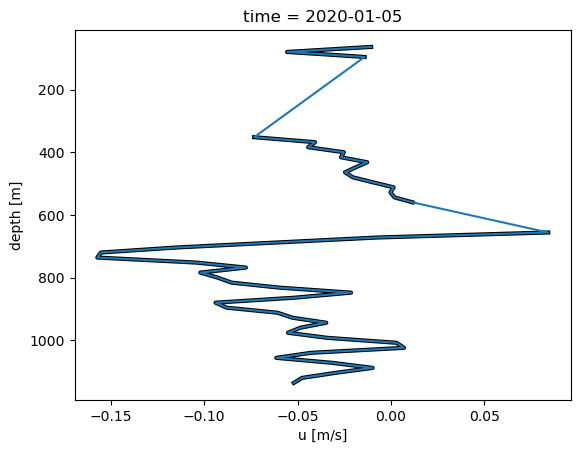

In [137]:
t = '2020-01-05'
ds.u.sel(time=t,method='nearest').plot(c='k',lw=3,y='z',yincrease=False)
ds_fill.u.sel(time=t,method='nearest').plot(y='z',yincrease=False)
#ds_fill_cubic.u.sel(time=t,method='nearest').plot(y='z',yincrease=False,ls='--')


plt.figure()
ds_gaps.u.sel(time=t,method='nearest').plot(lw=3,c='k',y='z',yincrease=False)
ds_gridded.u.sel(time=t,method='nearest').plot(y='z',yincrease=False)


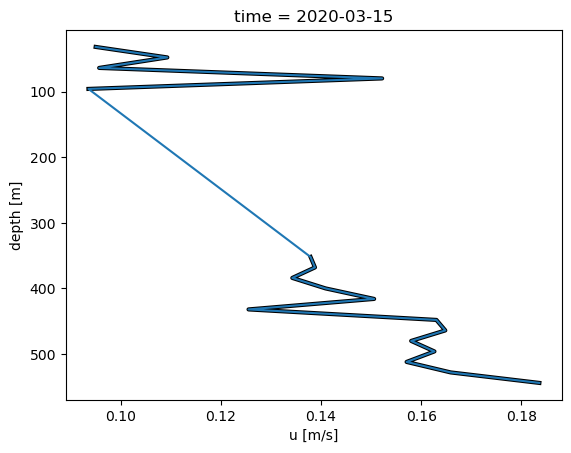

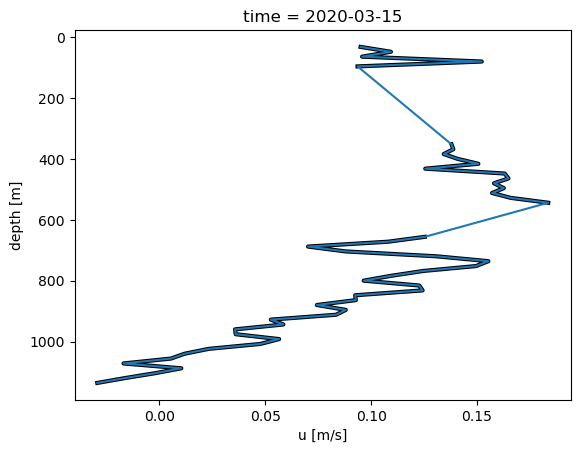

In [136]:
t = '2020-03-15'
ds.u.sel(time=t,method='nearest').plot(c='k',lw=3,y='z',yincrease=False)
ds_fill.u.sel(time=t,method='nearest').plot(y='z',yincrease=False)
#ds_fill_cubic.u.sel(time=t,method='nearest').plot(y='z',yincrease=False,ls='--')


plt.figure()
ds_gaps.u.sel(time=t,method='nearest').plot(lw=3,c='k',y='z',yincrease=False)
ds_gridded.u.sel(time=t,method='nearest').plot(y='z',yincrease=False)


### Notes
A cubic (or quadratic) interpolation to fill gaps in the depth range is doing better than a linear one in large gaps.
The impact of a change of interpolation method should be investigated after filtering.

In [138]:
ds_gridded

<xarray.Dataset>
Dimensions:       (z: 101, time: 73152, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-16T15:00:00 ... 2020-10-05T14...
  * z             (z) int64 0 16 32 48 64 80 ... 1520 1536 1552 1568 1584 1600
  * adcp          (adcp) int64 3110 10219 10185
Data variables:
    u             (z, time) float64 ...
    v             (z, time) float64 ...
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
Attributes:
    project:       NISKINe
    mooring:       M2
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

In [139]:
arraylist

[<xarray.Dataset>
 Dimensions:       (z: 75, time: 73658)
 Coordinates:
   * time          (time) datetime64[ns] 2019-05-16T08:00:27.999799 ... 2020-1...
   * z             (z) float64 300.0 308.0 316.0 324.0 ... 876.0 884.0 892.0
 Data variables: (12/15)
     pg            (z, time) int8 ...
     u             (z, time) float32 ...
     v             (z, time) float32 ...
     w             (z, time) float32 ...
     e             (z, time) float32 ...
     u_std         (z, time) float32 ...
     ...            ...
     amp           (z, time) float32 ...
     temperature   (time) float32 ...
     pressure      (time) float32 ...
     pressure_std  (time) float32 ...
     pressure_max  (time) float32 ...
     npings        (time) int16 ...
 Attributes:
     orientation:      down
     magdec:           -10.863953
     max_e:            0.2
     max_e_deviation:  2
     min_correlation:  64
     mooring:          M2
     sn:               10219
     project:          NISKINe
     Bin1